# Image denoising using total variation

In [ ]:
%%capture
!pip install kornia
!pip install kornia-rs

In [ ]:
import kornia as K
import matplotlib.pyplot as plt
import torch
import torchvision

In [ ]:
def imshow(input: torch.Tensor):
    out = torchvision.utils.make_grid(input, nrow=2, padding=5)
    out_np = K.utils.tensor_to_image(out)
    plt.imshow(out_np)
    plt.axis("off")
    plt.show()

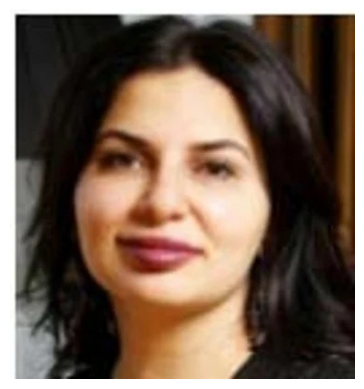

In [ ]:
# read the image with kornia and add a random noise to it
noisy_image = K.io.load_image("/content/ruja ignatova.jpg", K.io.ImageLoadType.RGB32)  # CxHxW

#noisy_image = (img + torch.normal(torch.zeros_like(img), 0.1)).clamp(0, 1)
imshow(noisy_image)

We define the total variation denoising network and the optimizer

In [ ]:
# define the total variation denoising network


class TVDenoise(torch.nn.Module):
    def __init__(self, noisy_image):
        super().__init__()
        self.l2_term = torch.nn.MSELoss(reduction="mean")
        self.regularization_term = K.losses.TotalVariation()
        # create the variable which will be optimized to produce the noise free image
        self.clean_image = torch.nn.Parameter(data=noisy_image.clone(), requires_grad=True)
        self.noisy_image = noisy_image

    def forward(self):
        return self.l2_term(self.clean_image, self.noisy_image) + 0.0001 * self.regularization_term(self.clean_image)

    def get_clean_image(self):
        return self.clean_image


tv_denoiser = TVDenoise(noisy_image)

# define the optimizer to optimize the 1 parameter of tv_denoiser
optimizer = torch.optim.SGD(tv_denoiser.parameters(), lr=0.1, momentum=0.9)

Run the the optimization loop

In [ ]:
num_iters: int = 200
for i in range(num_iters):
    optimizer.zero_grad()
    loss = tv_denoiser().sum()
    if i % 50 == 0:
        print(f"Loss in iteration {i} of {num_iters}: {loss.item():.3f}")
    loss.backward()
    optimizer.step()

Loss in iteration 0 of 500: 0.848
Loss in iteration 50 of 500: 0.831
Loss in iteration 100 of 500: 0.817
Loss in iteration 150 of 500: 0.805
Loss in iteration 200 of 500: 0.793
Loss in iteration 250 of 500: 0.784
Loss in iteration 300 of 500: 0.775
Loss in iteration 350 of 500: 0.766
Loss in iteration 400 of 500: 0.759
Loss in iteration 450 of 500: 0.752


Visualize the noisy and resulting cleaned image

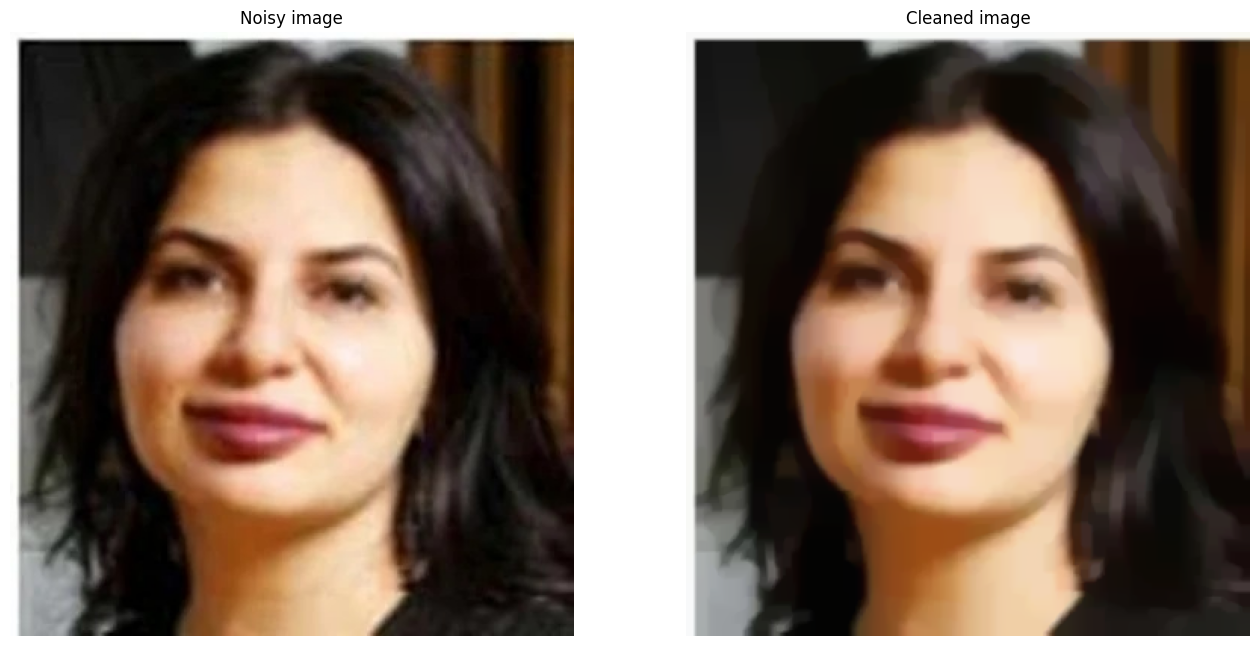

In [ ]:
# convert back to numpy
img_clean = K.utils.tensor_to_image(tv_denoiser.get_clean_image())

# Create the plot
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs = axs.ravel()

axs[0].axis("off")
axs[0].set_title("Noisy image")
axs[0].imshow(K.tensor_to_image(noisy_image))

axs[1].axis("off")
axs[1].set_title("Cleaned image")
axs[1].imshow(img_clean)

plt.show()

In [ ]:
# Surveillance part

device = torch.device('cpu') if not torch.cuda.is_available() else torch.device('cuda')

names = ['AC', 'BP', 'DT', 'LM', 'LS', 'OC']

for name in names:
  for i in range(1,3):
    noisy_image = K.io.load_image(f"/content/images/{name}{i}.jpg", K.io.ImageLoadType.RGB32, device=device)  # CxHxW

    tv_denoiser = TVDenoise(noisy_image)
    optimizer = torch.optim.SGD(tv_denoiser.parameters(), lr=0.1, momentum=0.9)

    num_iters: int = 200
    for j in range(num_iters):
        optimizer.zero_grad()
        loss = tv_denoiser().sum()
        loss.backward()
        optimizer.step()

    img_clean = K.utils.tensor_to_image(tv_denoiser.get_clean_image())
    img_clean = np.transpose(img_clean, (2,0,1))
    img_clean = torch.from_numpy(img_clean).mul(255.0).byte()

    K.io.write_image(f"/content/out/TVDenoise_{name}{i}.jpg", img_clean)

FileExistsError: File does not exist: /content/images/AC1.jpg